# 데이터 불러오기

In [ ]:
!pip install tensorflow-datasets

In [ ]:
!pip install tfds-nightly

# 데이터 준비

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds


ds = tfds.load('lost_and_found', split='train', batch_size=200)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0.incomplete9QMNFK/lost_and_found-train.tfrecord


  0%|          | 0/1036 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0.incomplete9QMNFK/lost_and_found-test.tfrecord


  0%|          | 0/1203 [00:00<?, ? examples/s]

Dataset lost_and_found downloaded and prepared to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset = next(iter(ds))

In [ ]:
print(dataset.keys())

dict_keys(['image_id', 'image_left', 'segmentation_label'])


In [ ]:
images = dataset['image_left'].numpy()
labels = dataset['segmentation_label'].numpy()

In [ ]:
print(images.shape)
print(labels.shape)

(200, 1024, 2048, 3)
(200, 1024, 2048, 1)


In [ ]:
labels[labels>1] = 1

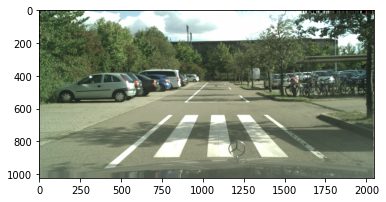

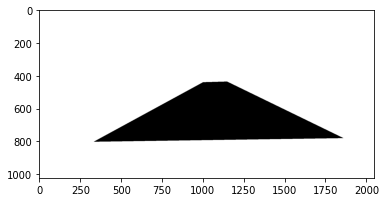

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

# 타겟 그림 확인
plt.imshow(labels[0].squeeze(), cmap='binary')
plt.show()

In [ ]:
print(labels[0][700,500:550,:].squeeze())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


## 참고

In [ ]:
a= np.arange(12)
print(a)

def double(v):
  return v*2

b= [double(i) for i in a]
print(b)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]


In [ ]:
img = images[0]
plt.imshow(img)
plt.show()

import cv2
res = cv2.resize(img, dsize=(54, 140), interpolation=cv2.INTER_NEAREST)

plt.imshow(res)
plt.show()

In [ ]:
a = np.arange(12).reshape(3,4)
print(a.shape)

a = np.expand_dims(a, axis=1)
print(a.shape)

a = a.squeeze()
print(a.shape)

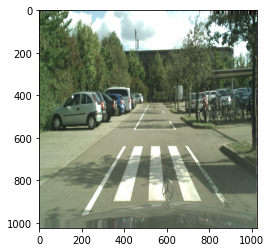

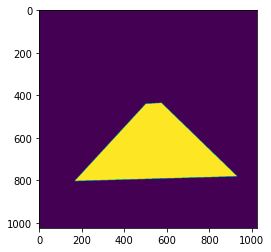

In [ ]:
# img = images[0]
# plt.imshow(img)
# plt.show()

# import cv2
# images = cv2.resize(images[0], dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
# labels = cv2.resize(labels[0], dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)

# plt.imshow(images)
# plt.show()

# plt.imshow(labels)
# plt.show()

## 이미지 크기 리사이즈

In [ ]:
# 백업 데이터
x = images
y = labels

# resize

In [ ]:
import cv2

def re(image):
  image = cv2.resize(image, dsize=(256,256), interpolation=cv2.INTER_NEAREST)
  return image


In [ ]:
# 200개의 데이터에 모두 적용
x=[re(x[i]) for i in range(200)]
y=[re(y[i]) for i in range(200)]

In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
print(x.shape)
print(y.shape)

(200, 256, 256, 3)
(200, 256, 256)


## 데이터 정규화

In [ ]:
x_all = x.astype(np.float) / 255.
y_all = y.astype(np.int)

In [ ]:
print(x_all.shape)
print(y_all.shape)

(200, 256, 256, 3)
(200, 256, 256)


x와 y의 shape가 다름.

## 데이터 나누기

In [ ]:
split_index = int(x_all.shape[0]*0.8)
train_x, test_x = x_all[:split_index], x_all[split_index:]
train_y, test_y = y_all[:split_index], y_all[split_index:]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(160, 256, 256, 3)
(160, 256, 256)
(40, 256, 256, 3)
(40, 256, 256)


train


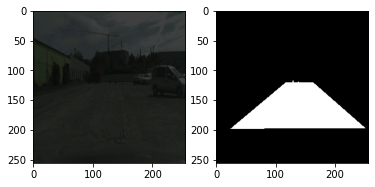

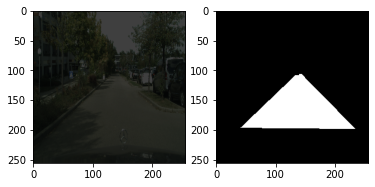

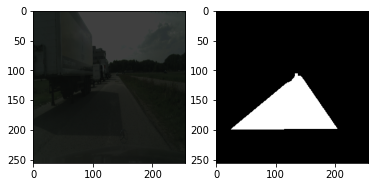

test


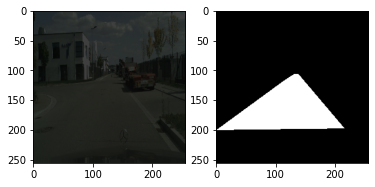

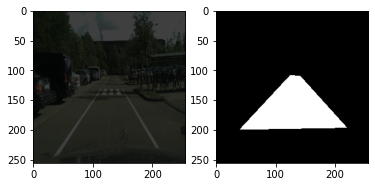

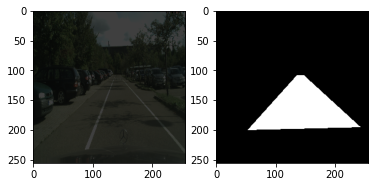

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,256,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

# U-Net 모델

In [ ]:
# 모델 정의

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    # 줄어든 이미지를 다시 원이미지로 키울 때 사용
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)   # 이미지 2배 키워줌?
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=500, batch_size=8, verbose=1)


Epoch 1/500
16/16 [==============================] - 46s 125ms/step - loss: 0.2715 - accuracy: 0.5717 - val_loss: 0.2364 - val_accuracy: 0.8348
Epoch 2/500
16/16 [==============================] - 2s 95ms/step - loss: 0.2417 - accuracy: 0.6421 - val_loss: 0.2251 - val_accuracy: 0.8348
Epoch 3/500
16/16 [==============================] - 2s 95ms/step - loss: 0.2265 - accuracy: 0.6776 - val_loss: 0.2139 - val_accuracy: 0.8348
Epoch 4/500
16/16 [==============================] - 2s 94ms/step - loss: 0.2147 - accuracy: 0.7023 - val_loss: 0.2027 - val_accuracy: 0.8348
Epoch 5/500
16/16 [==============================] - 2s 94ms/step - loss: 0.2043 - accuracy: 0.7217 - val_loss: 0.1910 - val_accuracy: 0.8348
Epoch 6/500
16/16 [==============================] - 2s 95ms/step - loss: 0.1957 - accuracy: 0.7363 - val_loss: 0.1798 - val_accuracy: 0.8348
Epoch 7/500
16/16 [==============================] - 2s 95ms/step - loss: 0.1858 - accuracy: 0.7516 - val_loss: 0.1683 - val_accuracy: 0.8348
Epoc

# 학습시 로스와 정확도 보기

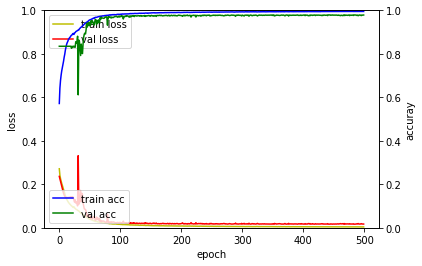

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 테스트 결과 보기

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:], 'gray')      # CHANGE <---------------- x와 y의 shape가 달라서 바꿔줌
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:], 'gray')      # CHANGE <---------------- x와 y의 shape가 달라서 바꿔줌
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 458ms/step - loss: 0.0059 - accuracy: 0.9924


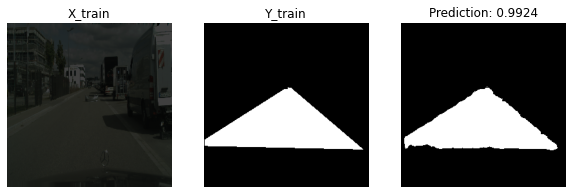

1/1 [==============================] - 0s 26ms/step - loss: 0.0170 - accuracy: 0.9775


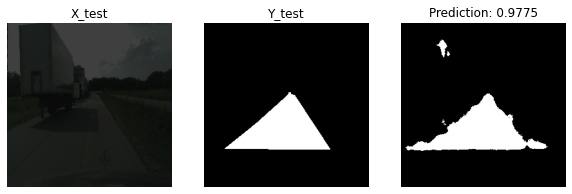

In [ ]:
plotPredictions(model, train_x, train_y, test_x, test_y)

# TR 정답

In [ ]:
!pip install tensorflow-datasets

In [ ]:
!pip install tfds-nightly

     |████████████████████████████████| 4.1 MB 14.5 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds


ds = tfds.load('lost_and_found', split='train', batch_size=200)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1036 [00:00<?, ? examples/s]

Shuffling lost_and_found-train.tfrecord...:   0%|          | 0/1036 [00:00<?, ? examples/s]

In [ ]:
dataset = next(iter(ds))

In [ ]:
print(dataset.keys())

In [ ]:
images = dataset['image_left'].numpy()
labels = dataset['segmentation_label'].numpy()

In [ ]:
print(images.shape)
print(labels.shape)

In [ ]:
labels[labels>1] = 1

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

plt.imshow(labels[0].squeeze(), cmap='binary')
plt.show()

In [ ]:
print(labels[0][700,500:550,:].squeeze())

# 이미지 크기 리사이즈

In [ ]:
def resize(image):
    return cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)

resized_images = np.array([resize(image) for image in images])
resized_labels = np.array([resize(label) for label in labels])

print(resized_images.shape)
print(resized_labels.shape)

In [ ]:
x = resized_images
y = np.expand_dims(resized_labels, axis=-1)

x,y의 shape가 안맞아서 y를 고쳐줌

y를 이렇게 설정해주면 테스트 결과 보기에서 고쳐줄 필요가 없음

# copy from Unet

## 데이터 나누기

In [ ]:
split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(160, 256, 256, 3)
(160, 256, 256, 1)
(40, 256, 256, 3)
(40, 256, 256, 1)


train


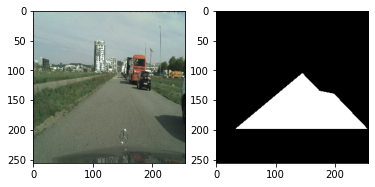

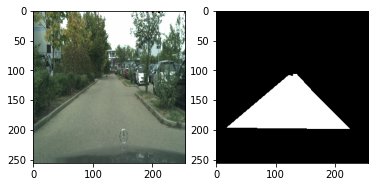

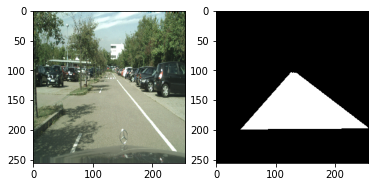

test


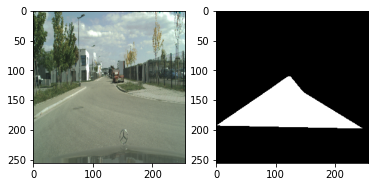

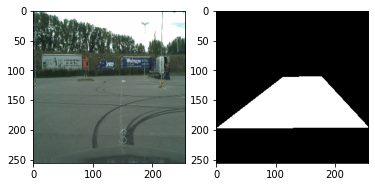

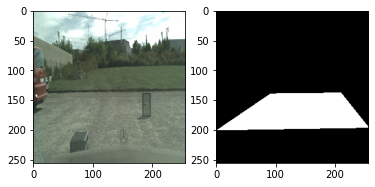

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

## U-Net 모델 정의

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

## 모델 컴파일과 학습

In [ ]:
# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="binary_crossentropy", optimizer="SGD", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=500, batch_size=32, verbose=1)


Epoch 1/500
4/4 [==============================] - 3s 337ms/step - loss: 0.7834 - accuracy: 0.5246 - val_loss: 0.6684 - val_accuracy: 0.6121
Epoch 2/500
4/4 [==============================] - 1s 196ms/step - loss: 0.7274 - accuracy: 0.5759 - val_loss: 0.6295 - val_accuracy: 0.7030
Epoch 3/500
4/4 [==============================] - 1s 196ms/step - loss: 0.6929 - accuracy: 0.6114 - val_loss: 0.6164 - val_accuracy: 0.7350
Epoch 4/500
4/4 [==============================] - 1s 196ms/step - loss: 0.6690 - accuracy: 0.6350 - val_loss: 0.6113 - val_accuracy: 0.7484
Epoch 5/500
4/4 [==============================] - 1s 197ms/step - loss: 0.6492 - accuracy: 0.6529 - val_loss: 0.5954 - val_accuracy: 0.7653
Epoch 6/500
4/4 [==============================] - 1s 196ms/step - loss: 0.6318 - accuracy: 0.6680 - val_loss: 0.5986 - val_accuracy: 0.7686
Epoch 7/500
4/4 [==============================] - 1s 197ms/step - loss: 0.6154 - accuracy: 0.6820 - val_loss: 0.5889 - val_accuracy: 0.7786
Epoch 8/500
4

## 학습시 로스와 정확도 보기

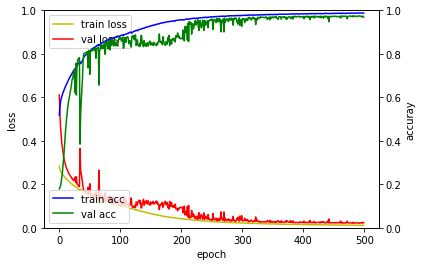

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 테스트 결과 보기

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

    # matplot에서는 흑백이면 shape가 2차원, 컬러면 3차원으로 표현해야함 ([:,:,0]으로 표현하는 이유)
    # 위 코드는 원래 컬러 이미지로 표현되지만 'gray'톤을 적용해서 흑백처럼 보이는것

1/1 [==============================] - 0s 385ms/step - loss: 0.0104 - accuracy: 0.9888


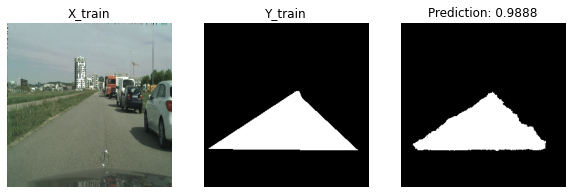

1/1 [==============================] - 0s 23ms/step - loss: 0.0234 - accuracy: 0.9700


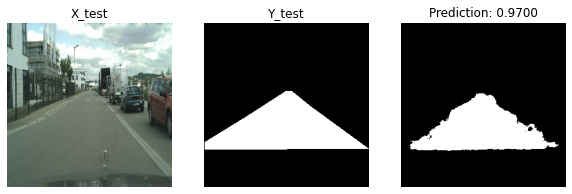

In [ ]:
plotPredictions(model, train_x, train_y, test_x, test_y)

# Mnet으로 해보기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds


ds = tfds.load('lost_and_found', split='train', batch_size=200)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0.incompleteMA4VA3/lost_and_found-train.tfrecord


  0%|          | 0/1036 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0.incompleteMA4VA3/lost_and_found-test.tfrecord


  0%|          | 0/1203 [00:00<?, ? examples/s]

Dataset lost_and_found downloaded and prepared to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset = next(iter(ds))

In [ ]:
print(dataset.keys())

dict_keys(['image_id', 'image_left', 'segmentation_label'])


In [ ]:
images = dataset['image_left'].numpy()
labels = dataset['segmentation_label'].numpy()

In [ ]:
print(images.shape)
print(labels.shape)

(200, 1024, 2048, 3)
(200, 1024, 2048, 1)


In [ ]:
# 색이 들어간 픽셀을 모두 1로 바꿔줌 (회색 -> 검정)
# 확실한 대비를 주기 휘애 바꿔줌

labels[labels>1] = 1

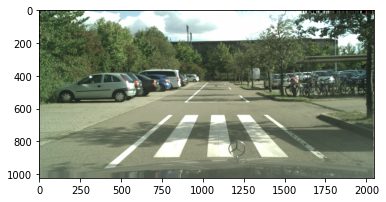

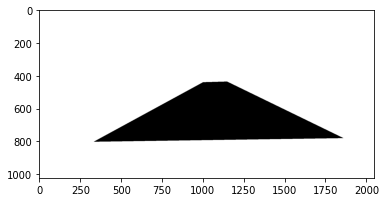

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

plt.imshow(labels[0].squeeze(), cmap='binary')
plt.show()

In [ ]:
print(labels[0][700,500:550,:].squeeze())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


# 이미지 크기 리사이즈

In [ ]:
import cv2

def resize(image):
    return cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)

resized_images = np.array([resize(image) for image in images])
resized_labels = np.array([resize(label) for label in labels])

print(resized_images.shape)
print(resized_labels.shape)

(200, 256, 256, 3)
(200, 256, 256)


In [ ]:
x = resized_images
y = np.expand_dims(resized_labels, axis=-1)

y를 이렇게 설정해주면 테스트 결과 보기에서 고쳐줄 필요가 없음

## 정규화

In [ ]:
x = x.astype(np.float) / 255.
y = y.astype(np.float)

## 데이터 나누기

In [ ]:
split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(160, 256, 256, 3)
(160, 256, 256, 1)
(40, 256, 256, 3)
(40, 256, 256, 1)


train


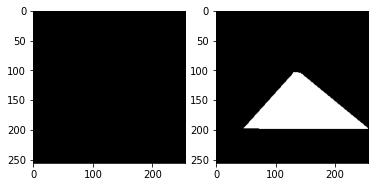

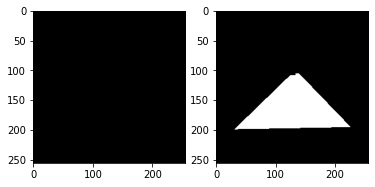

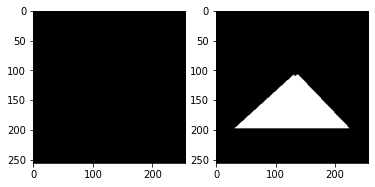

test


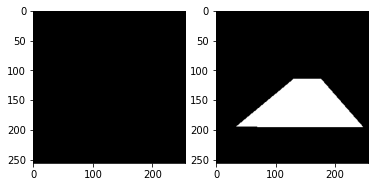

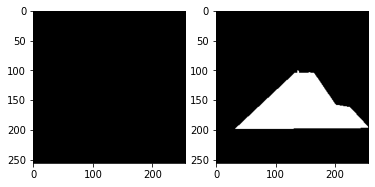

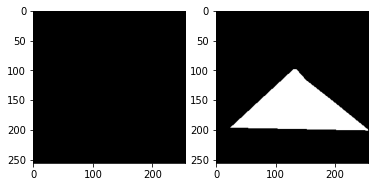

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

## MNET 모델 정의

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, UpSampling2D
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


def getFPDMNet(patchHeight, patchWidth, ipCh, outCh):

    # Input
    input1 = Input((patchHeight, patchWidth, ipCh))

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same')(input1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = concatenate([input1, conv1], axis=-1)
    conv1 = Conv2D(16, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #
    input2 = MaxPooling2D(pool_size=(2, 2))(input1)
    conv21 = concatenate([input2, pool1], axis=-1)

    conv2 = Conv2D(32, (3, 3), padding='same')(conv21)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(0.2)(conv2)

    conv2 = concatenate([conv21, conv2], axis=-1)
    conv2 = Conv2D(32, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #
    input3 = MaxPooling2D(pool_size=(2, 2))(input2)
    conv31 = concatenate([input3, pool2], axis=-1)

    conv3 = Conv2D(64, (3, 3), padding='same')(conv31)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(0.2)(conv3)
    
    conv3 = concatenate([conv31, conv3], axis=-1)
    conv3 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #
    input4 = MaxPooling2D(pool_size=(2, 2))(input3)
    conv41 = concatenate([input4, pool3], axis=-1)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv41)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)
    
    conv4 = concatenate([conv41, conv4], axis=-1)
    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    # Decoder
    conv5 = UpSampling2D(size=(2, 2))(conv4)
    conv51 = concatenate([conv3, conv5], axis=-1)

    conv5 = Conv2D(64, (3, 3), padding='same')(conv51)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Dropout(0.2)(conv5)
    
    conv5 = concatenate([conv51, conv5], axis=-1)
    conv5 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    #
    conv6 = UpSampling2D(size=(2, 2))(conv5)
    conv61 = concatenate([conv2, conv6], axis=-1)

    conv6 = Conv2D(32, (3, 3), padding='same')(conv61)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Dropout(0.2)(conv6)
    
    conv6 = concatenate([conv61, conv6], axis=-1)
    conv6 = Conv2D(32, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    #
    conv7 = UpSampling2D(size=(2, 2))(conv6)
    conv71 = concatenate([conv1, conv7], axis=-1)

    conv7 = Conv2D(16, (3, 3), padding='same')(conv71)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Dropout(0.2)(conv7)
    
    conv7 = concatenate([conv71, conv7], axis=-1)
    conv7 = Conv2D(16, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    # Final
    conv81 = UpSampling2D(size=(8, 8))(conv4)
    conv82 = UpSampling2D(size=(4, 4))(conv5)
    conv83 = UpSampling2D(size=(2, 2))(conv6)
    conv8 = concatenate([conv81, conv82, conv83, conv7], axis=-1)
    conv8 = Conv2D(outCh, (1, 1), activation='sigmoid')(conv8)

    ############
    model = Model(inputs=input1, outputs=conv8)

    # sgd = SGD(learning_rate=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)
    # model.compile(optimizer=sgd, loss=my_loss)

    return model

## 모델 컴파일과 학습

In [ ]:
# 모델 생성
# model = unet()
model = getFPDMNet(patchHeight=256, patchWidth=256, ipCh=3, outCh=1)

# 모델 컴파일
# model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

lrate = 0.1
decay_Rate = 1e-6

def my_loss(y_true, y_pred):
    l1_loss = K.mean(K.abs(y_pred - y_true))    # mae
    return l1_loss
    
sgd = SGD(learning_rate=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)
model.compile(optimizer=sgd, loss=my_loss, metrics=['accuracy'])


# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=200, batch_size=8, verbose=1)

Epoch 1/200
16/16 [==============================] - 4s 125ms/step - loss: 0.2075 - accuracy: 0.8090 - val_loss: 0.4189 - val_accuracy: 0.8348
Epoch 2/200
16/16 [==============================] - 2s 101ms/step - loss: 0.1640 - accuracy: 0.8372 - val_loss: 0.3691 - val_accuracy: 0.8348
Epoch 3/200
16/16 [==============================] - 2s 101ms/step - loss: 0.1636 - accuracy: 0.8372 - val_loss: 0.3269 - val_accuracy: 0.8348
Epoch 4/200
16/16 [==============================] - 2s 101ms/step - loss: 0.1635 - accuracy: 0.8372 - val_loss: 0.2924 - val_accuracy: 0.8348
Epoch 5/200
16/16 [==============================] - 2s 101ms/step - loss: 0.1634 - accuracy: 0.8372 - val_loss: 0.2651 - val_accuracy: 0.8348
Epoch 6/200
16/16 [==============================] - 2s 101ms/step - loss: 0.1633 - accuracy: 0.8372 - val_loss: 0.2445 - val_accuracy: 0.8348
Epoch 7/200
16/16 [==============================] - 2s 101ms/step - loss: 0.1632 - accuracy: 0.8372 - val_loss: 0.2283 - val_accuracy: 0.8348

## 학습시 로스와 정확도 보기

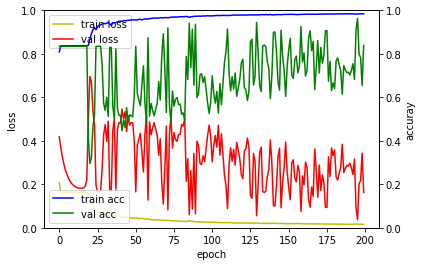

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 테스트 결과 보기

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 338ms/step - loss: 0.1028 - accuracy: 0.8984


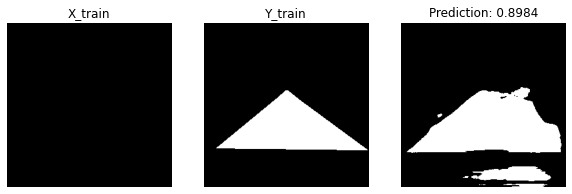

1/1 [==============================] - 0s 23ms/step - loss: 0.1562 - accuracy: 0.8462


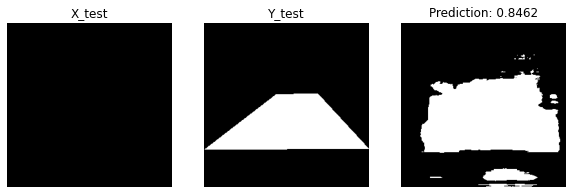

In [ ]:
plotPredictions(model, train_x, train_y, test_x, test_y)